In [1]:
# import libraries
import numpy as np
np.set_printoptions(precision = 4, suppress = True)
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import json

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# import modules
from widgets import CandlestickWidget

import mplfinance as mpf

In [2]:
out_dir = "./data/out"
in_dir = "./data/in"

In [3]:
experiment_name = "set-1/03"
optimizer_name = "brute force"

optimizer_dir = os.path.join(out_dir, optimizer_name)
experiment_dir = os.path.join(optimizer_dir, experiment_name)
series_dir = os.path.join(experiment_dir, "best-series")

In [4]:
# read settings
settings_path = os.path.join(experiment_dir, "settings.json")
file = open(settings_path, "r")
settings_doc = json.loads(file.read())
pair_doc = settings_doc["candles"]["currency pair"];
base_name = pair_doc["base"]
quote_name = pair_doc["quote"]

In [5]:
candles_path = os.path.join(in_dir, "{}{}.csv".format(base_name, quote_name))
asset_name = "{}/{}".format(base_name, quote_name)

In [6]:
def get_series(csv_path, sep=',', time_col="time"):
    series = pd.read_csv(csv_path, sep)
    series.drop(index=0)
    series[time_col] = pd.to_datetime(series[time_col], unit='s')
    series.set_index(time_col, inplace=True)
    return series

In [7]:
def read_candles(path):
    column_names = ["time", "open", "high", "low", "close", "volume"]
    candles = pd.read_csv(candles_path, '|', names=column_names, usecols=range(6), header=None)
    candles.set_index("time", inplace=True)
    candles.index = pd.to_datetime(candles.index,unit='s')
    return candles

In [8]:
candle_series = read_candles(candles_path)

In [9]:
# get series
close_balance_series = get_series(os.path.join(series_dir, "close-balance-series.csv"))
equity_series = get_series(os.path.join(series_dir, "equity-series.csv"))
open_order_series = get_series(os.path.join(series_dir, "open-order-series.csv"))
close_order_series = get_series(os.path.join(series_dir, "close-order-series.csv"))
exit_indic_series = get_series(os.path.join(series_dir, "exit-indic-series.csv"))
entry_indic_series = get_series(os.path.join(series_dir, "entry-indic-series.csv"))

In [10]:
# rename index
index_name = "Čas"
close_balance_series.index.name = index_name
equity_series.index.name = index_name
open_order_series.index.name = index_name
close_order_series.index.name = index_name
exit_indic_series.index.name = index_name
entry_indic_series.index.name = index_name

In [11]:
# rename columns
time_col = "Čas"
entry_level_pattern = "{}. vstupní úroveň"

entry_column_names = []
for i in range(len(entry_indic_series.columns)):
        entry_column_names.append(entry_level_pattern.format(i+1))

equity_column_name = "Čistá hodnota"
equity_series.columns = [equity_column_name]
close_balance_column_name = "Zůstatek po uzavření pozice"
close_balance_series.columns = [close_balance_column_name]
open_order_series.columns = ["Otevírací objednávka"]
close_order_series.columns = ["Uzavírací objednávka"]
exit_indic_series.columns = ["Výstupní úroveň"]
entry_indic_series.columns = entry_column_names

In [12]:
last_idx = candle_series.index[-1]
close_balance_series = close_balance_series.append(pd.DataFrame(index=[last_idx]))
close_balance_series[last_idx] = close_balance_series[close_balance_column_name][-2]

equity_series = equity_series.append(pd.DataFrame(index=[last_idx]))
equity_series[last_idx] = equity_series[equity_column_name][-2]

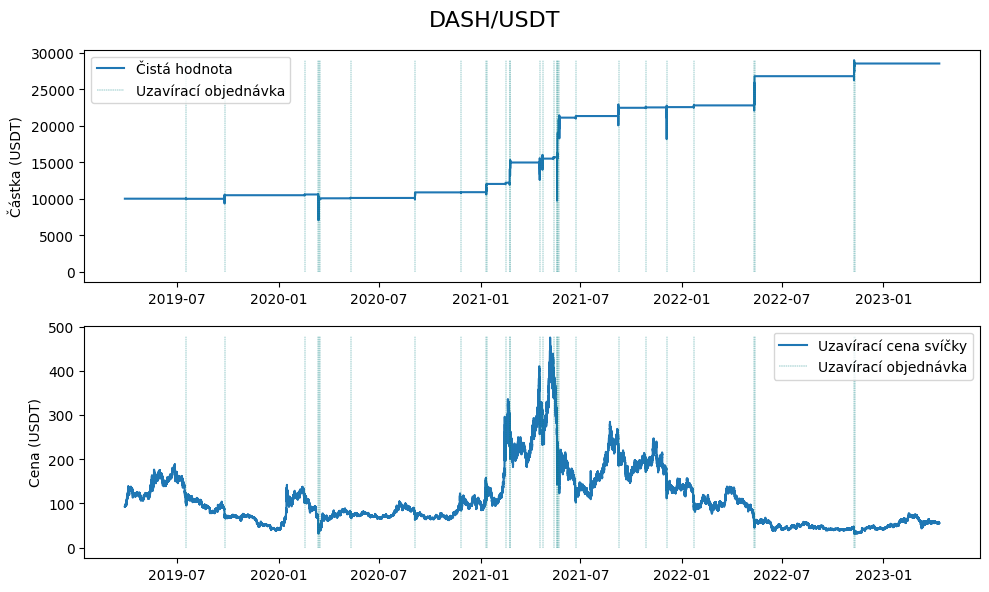

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
data_name = ""
fig.suptitle("{}".format(asset_name), fontsize=16)

amount_name = "Částka ({})".format(quote_name)
price_name = "Cena ({})".format(quote_name)

close_order_label = "Uzavírací objednávka"

ax1.step(equity_series.index, equity_series[equity_column_name], where="post", label=equity_column_name)
ax1.set_ylabel(amount_name)
ax1.vlines(close_order_series.index, ymin=0, ymax=equity_series[equity_column_name].max(),
           label=close_order_label, colors='teal', ls='--', lw=0.3)
ax1.legend()

ax2.plot(candle_series.index, candle_series['close'], label="Uzavírací cena svíčky");
ax2.set_ylabel(price_name)
ax2.vlines(close_order_series.index, ymin=0, ymax=candle_series["high"].max(),
           label=close_order_label, colors='teal', ls='--', lw=0.3)
ax2.legend()

fig.tight_layout()

In [14]:
# fig.savefig(os.path.join(experiment_dir, "historical-simulation.png"), bbox_inches='tight', dpi=200)

In [15]:
# reindex
entry_indic_series = entry_indic_series.reindex(candle_series.index)
open_order_series = open_order_series.reindex(candle_series.index)
close_order_series = close_order_series.reindex(candle_series.index)
exit_indic_series = exit_indic_series.reindex(candle_series.index)
entry_indic_series = entry_indic_series.reindex(candle_series.index)

In [17]:
%matplotlib qt

minute = 60
day = minute*24
week = day*7
month = week*4
year = day*365

visible_points_count = [3*day]
title = asset_name

for points_count in visible_points_count:
    widget = CandlestickWidget(candle_series, entry_indic_series, exit_indic_series, open_order_series,
                           close_order_series, title, points_count)
    widget.show()

2023-04-26 20:01:26.570 Python[81498:2838046] +[CATransaction synchronize] called within transaction
2023-04-26 20:01:27.030 Python[81498:2838046] +[CATransaction synchronize] called within transaction
